In [24]:
import torch
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import umap
from sklearn.preprocessing import StandardScaler
import similarity

pl_cfg = pl.Config()
pl_cfg.set_tbl_rows(2000)

polars.config.Config

In [2]:
df = pl.read_parquet("data/out/movie-script-dataset.parquet")
embeddings = torch.load("data/out/scripts-embedded.pt", weights_only=True)
print(df.shape)
print(embeddings.shape)
print(embeddings.dtype)

(110, 9)
torch.Size([110, 1024])
torch.float32


In [3]:
simpairs = similarity.calculate_all_similarity_pairs(embeddings)
for k, v in simpairs.items():
    print(f"{k}: {v.shape}")

Dotproduct: torch.Size([110, 110])
Cosine: torch.Size([110, 110])
Distance: torch.Size([110, 110])


### Get correlation between similarity measures

In [ ]:
simdf = pl.DataFrame(
    {
        k: v.flatten().numpy() for k, v in simpairs.items()
    }
)

corrdf = simdf.select(pl.col(pl.Float32, pl.Float64)).corr()

fig_corr = px.imshow(
    corrdf,
    labels=dict(x="Metric", y="Metric", color="Correlation"),
    x=["Dotproduct", "Cosine", "Distance"],
    y=["Dotproduct", "Cosine", "Distance"],
    color_continuous_scale="Portland"
)
fig_corr.update_layout(title="Similarity Metrics Correlation Heatmap")


In [14]:
reducer = umap.UMAP(n_components=2, random_state=42)

embeddings_lowdim = reducer.fit_transform(embeddings)
embeddings_lowdim.shape

/Users/anders/Desktop/learning/internet-movie-script-dataset/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/anders/Desktop/learning/internet-movie-script-dataset/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(110, 2)

In [15]:
df = df.with_columns(
    main_genre = \
    pl.when(pl.col("genre").str.contains('Fantasy'))
    .then(pl.lit("Fantasy"))
    .when(pl.col("genre").str.contains('Crime'))
    .then(pl.lit("Crime"))
    .when(pl.col("genre").str.contains('Musical'))
    .then(pl.lit("Musical"))
    .when(pl.col("genre").str.contains('Horror'))
    .then(pl.lit("Horror"))
    .when(pl.col("genre").str.contains('SciFi'))
    .then(pl.lit("SciFi"))
    .when(pl.col("genre").str.contains('Thriller'))
    .then(pl.lit("Thriller"))
    .when(
        pl.col("genre").str.contains('Animation') & 
        pl.col("genre").str.contains("Comedy")
    )
    .then(pl.lit("Comedy"))
    .when(pl.col("genre").str.contains("Adventure"))
    .then(
        pl.when(pl.col("genre").str.contains("Animation"))
        .then(pl.lit("Animation"))
        .when(pl.col("genre").str.contains("Comedy"))
        .then(pl.lit("Adventure"))
        .when(pl.col("genre").str.contains("Action"))
        .then(pl.lit("Action"))
        .otherwise(pl.lit("Adventure"))
    )
    .when(pl.col("genre").str.contains("Comedy"))
    .then(pl.lit("Comedy"))
    .when(pl.col("genre").str.contains("Drama"))
    .then(pl.lit("Drama"))
    .when(pl.col("genre").str.contains("Action"))
    .then(pl.lit("Action"))
    .when(pl.col("genre").str.contains("Animation"))
    .then(pl.lit("Animation"))
    .when(pl.col("genre").is_null())
    .then(pl.lit(None))
    .otherwise(pl.lit("Other"))

    ,is_animated = pl.col("genre").str.contains("Animation")
)
df.select(pl.col("movie_title", "genre", "main_genre", "is_animated")).head()

movie_title,genre,main_genre,is_animated
str,str,str,bool
"""12 Angry Men""","""Crime,Drama""","""Crime""",false
"""15 Minutes""","""Action,Crime,Drama,Thriller""","""Crime""",false
"""2012""","""Action,Adventure,Drama,SciFi,T…","""SciFi""",false
"""30 Minutes or Less""","""Action,Adventure,Comedy""","""Adventure""",false
"""48 Hrs""","""Action,Comedy,Thriller""","""Thriller""",false


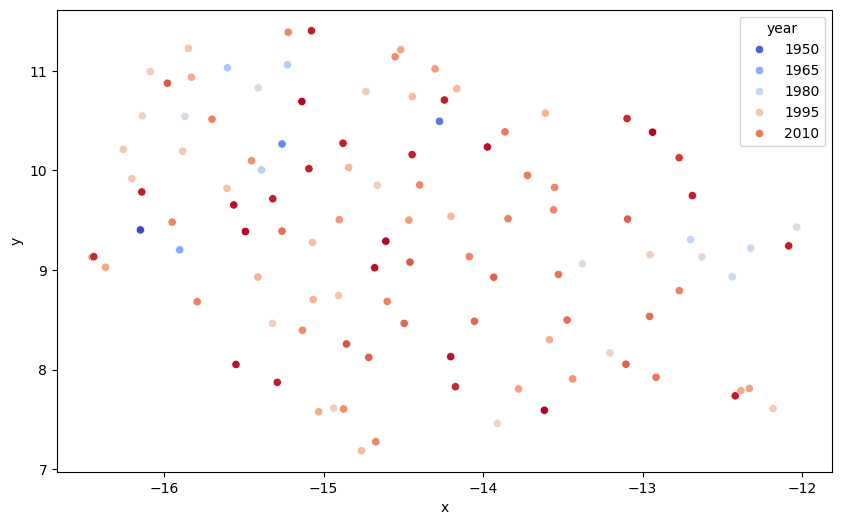

In [16]:
emblow = pd.DataFrame(embeddings_lowdim, columns = ['x', 'y'])
emblow = pl.from_pandas(emblow).with_row_index().join(
    df.with_columns(
        script_length = pl.col("script").str.len_chars()
    ).select(pl.col("index", "movie_title", "year", "genre", "main_genre", "script_length")),
    on = 'index',
    how = 'inner'
)

fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow,
    x='x',
    y='y',
    hue='year',
    palette='coolwarm'
)

plt.show()

In [17]:
import itertools

df = df.with_columns(
    # genre is a comma separated string with no spaces, and no duplicates within the same string
    pl.col("genre").str.split(",")
    .map_elements(lambda x: [i for i in x if i != ""])
    .map_elements(lambda genres: list(itertools.combinations(sorted(genres), 2)))
    .alias("genre_combinations")
)

df["genre_combinations"].explode().value_counts(sort=True).head(1)

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_1846/509711688.py:3: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_1846/509711688.py:3: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



genre_combinations,count
list[str],u32
"[""Animation"", ""Comedy""]",35


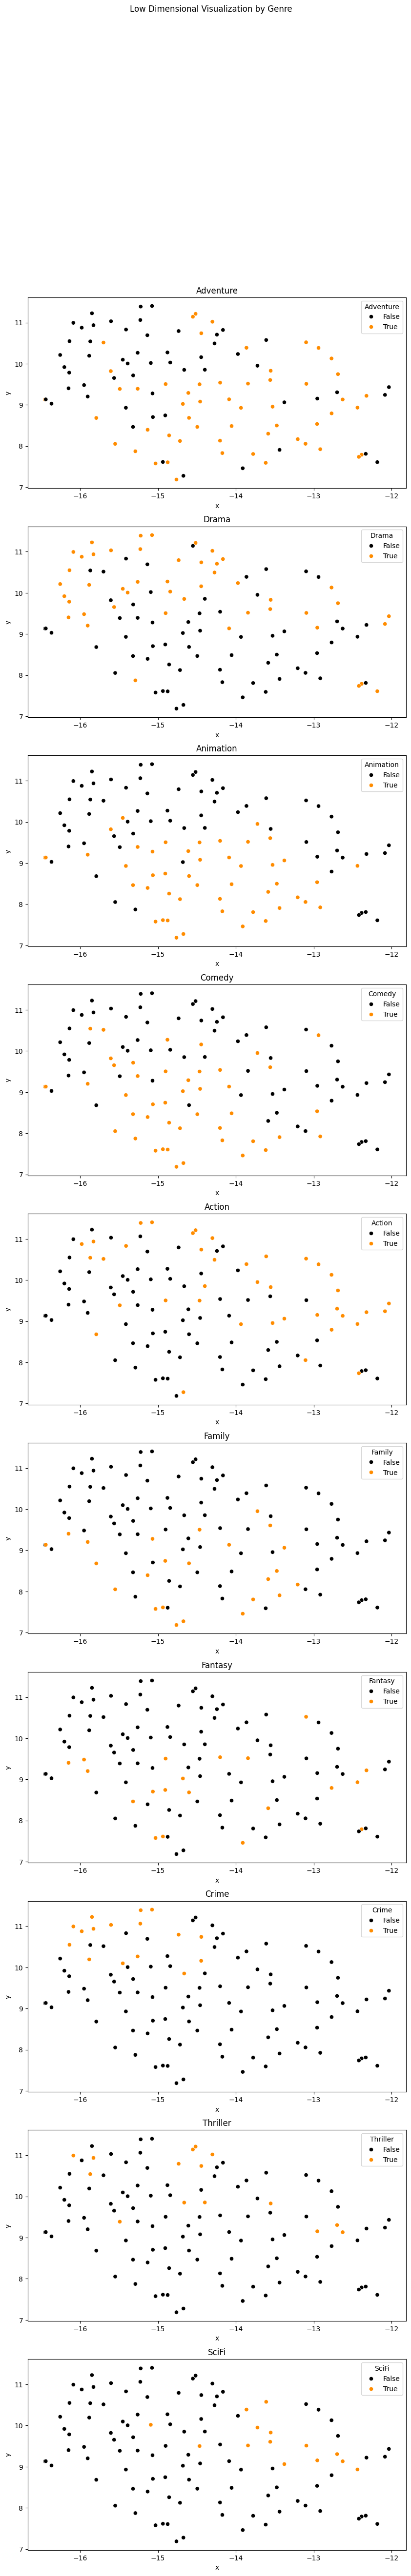

In [18]:
genre_counts = df["genre"].str.replace_all(r'[\s]', '')\
    .str.replace_all(r'[,]+', ',')\
    .str.split(",").explode().value_counts()\
    .sort(pl.col("count"), descending=True)

nplots = 10

fig, axes = plt.subplots(nplots,1,figsize=(10,6*nplots))
fig.suptitle("Low Dimensional Visualization by Genre")

for i in range(nplots):

    sns.scatterplot(
        emblow.with_columns(
            pl.col("genre").str.contains(genre_counts[i, "genre"])
            .alias(genre_counts[i, "genre"])
        ),
        x='x',
        y='y',
        hue=genre_counts[i, "genre"],
        ax=axes[i],
        palette=["k", "darkorange"]
    )
    axes[i].set_title(genre_counts[i, "genre"])

plt.show()

In [19]:
label_movies = [
    '12 Angry Men',
 'Aladdin',
 'Avatar',
 'Avengers: Endgame',
 'Barbie',
 'Black Panther Wakanda Forever',
 'Cidade de Deus (City of God)',
 'Coco',
 'The Dark Knight',
 'Fight Club',
 'Forrest Gump',
 "The Bourne Identity",
 'Frozen (Disney)',
 'The Godfather',
 'Fantastic Mr Fox',
 'Nope',
 'The LEGO Movie',
 'Coraline',
 'Harry Potter and the Half Blood Prince',
 'Inception',
 'The Shawshank Redemption',
 'Shrek',
 'Interstellar',
 "It's a Wonderful Life",
 'The Lord of the Rings The Fellowship of the Ring',
 'The Matrix',
 'Star Wars Episode V The Empire Strikes Back',
 'The Nightmare Before Christmas',
 'Pulp Fiction',
 'Saving Private Ryan',
 'Wall-E',
 'Up'
]
print(len(label_movies))

32


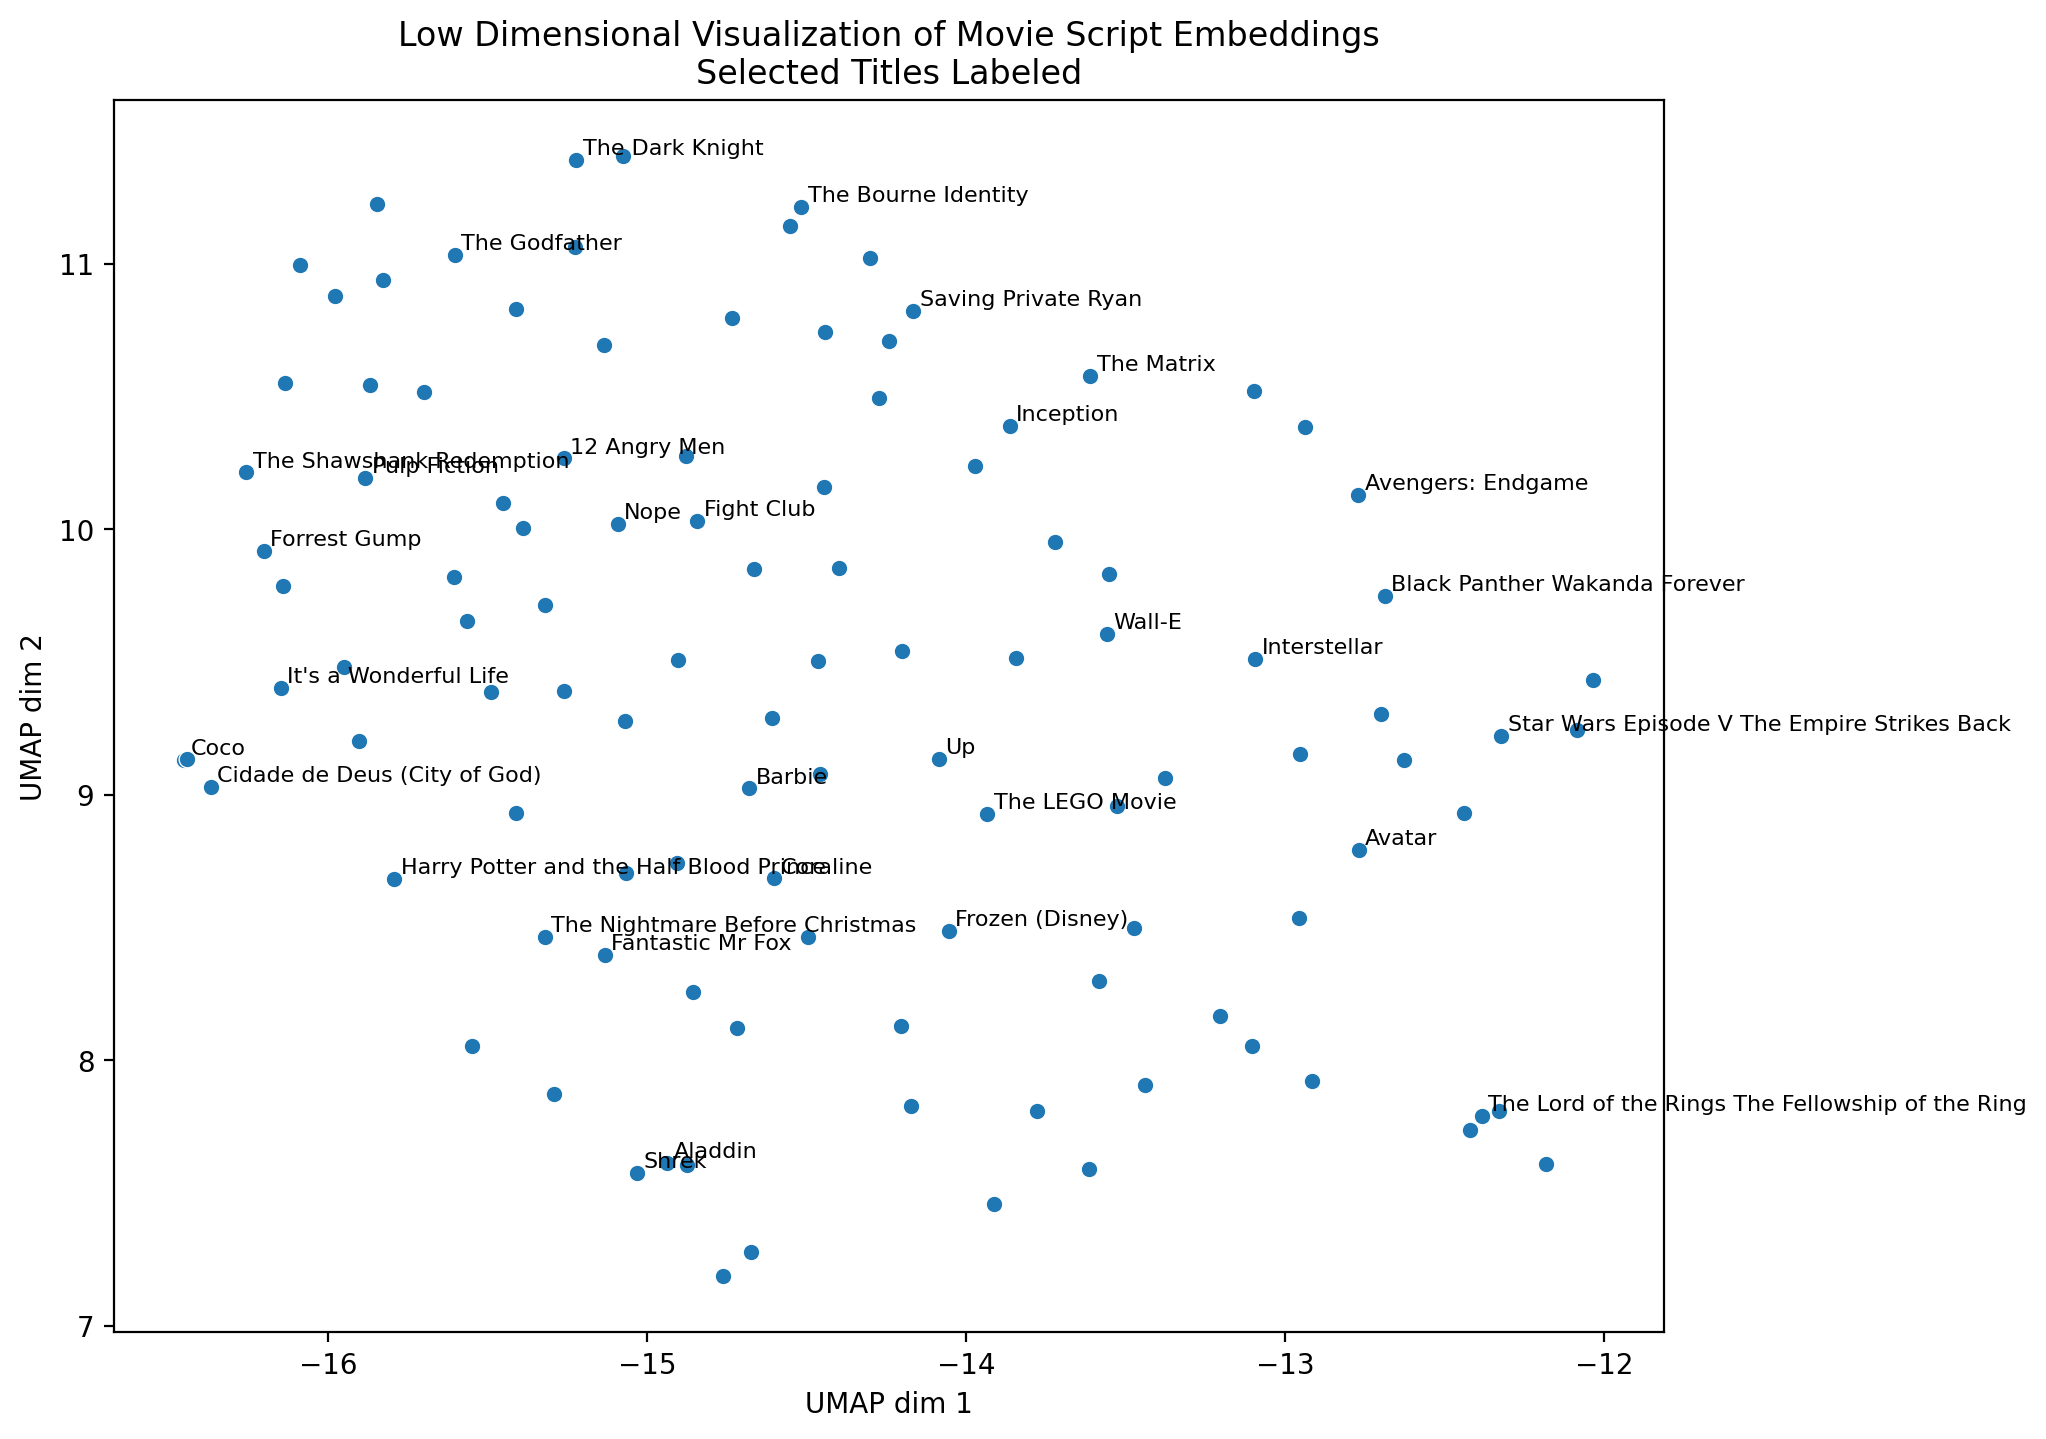

In [20]:
movies_to_label_on_plot = emblow.filter(pl.col("movie_title").is_in(label_movies))
# feel free to use emblow.to_pandas() if you
# are more comfortable with that package

fig, ax = plt.subplots( figsize=(10,8), dpi=200)

ax.set_title("Low Dimensional Visualization of Movie Script Embeddings\nSelected Titles Labeled")

sns.scatterplot(
    emblow,
    x='x',
    y='y'
)

ax.set_xlabel("UMAP dim 1")
ax.set_ylabel("UMAP dim 2")

for i in range(movies_to_label_on_plot.shape[0]):
    ax.text(
        movies_to_label_on_plot[i, 'x'] + 0.02,            # small offset in x
        movies_to_label_on_plot[i, 'y'] + 0.02,            # small offset in y
        movies_to_label_on_plot[i, 'movie_title'], 
        fontsize=8
    )
plt.show()


In [41]:

franchises = [
    "Bourne",
    "Alien",
    "Batman",
    "Lord of the Rings",
    "Godfather",
    "Inside Out",
    "Shrek",
    "Top Gun"
]

emblow = emblow.with_columns(
    pl.col("movie_title").str.replace("The Dark Knight", "Batman")
    .map_elements(lambda x: max([f if (f in x) else ".No sequels included" for f in franchises]), return_dtype=pl.String)
    .alias("Franchise")
)

In [ ]:

plt.show()


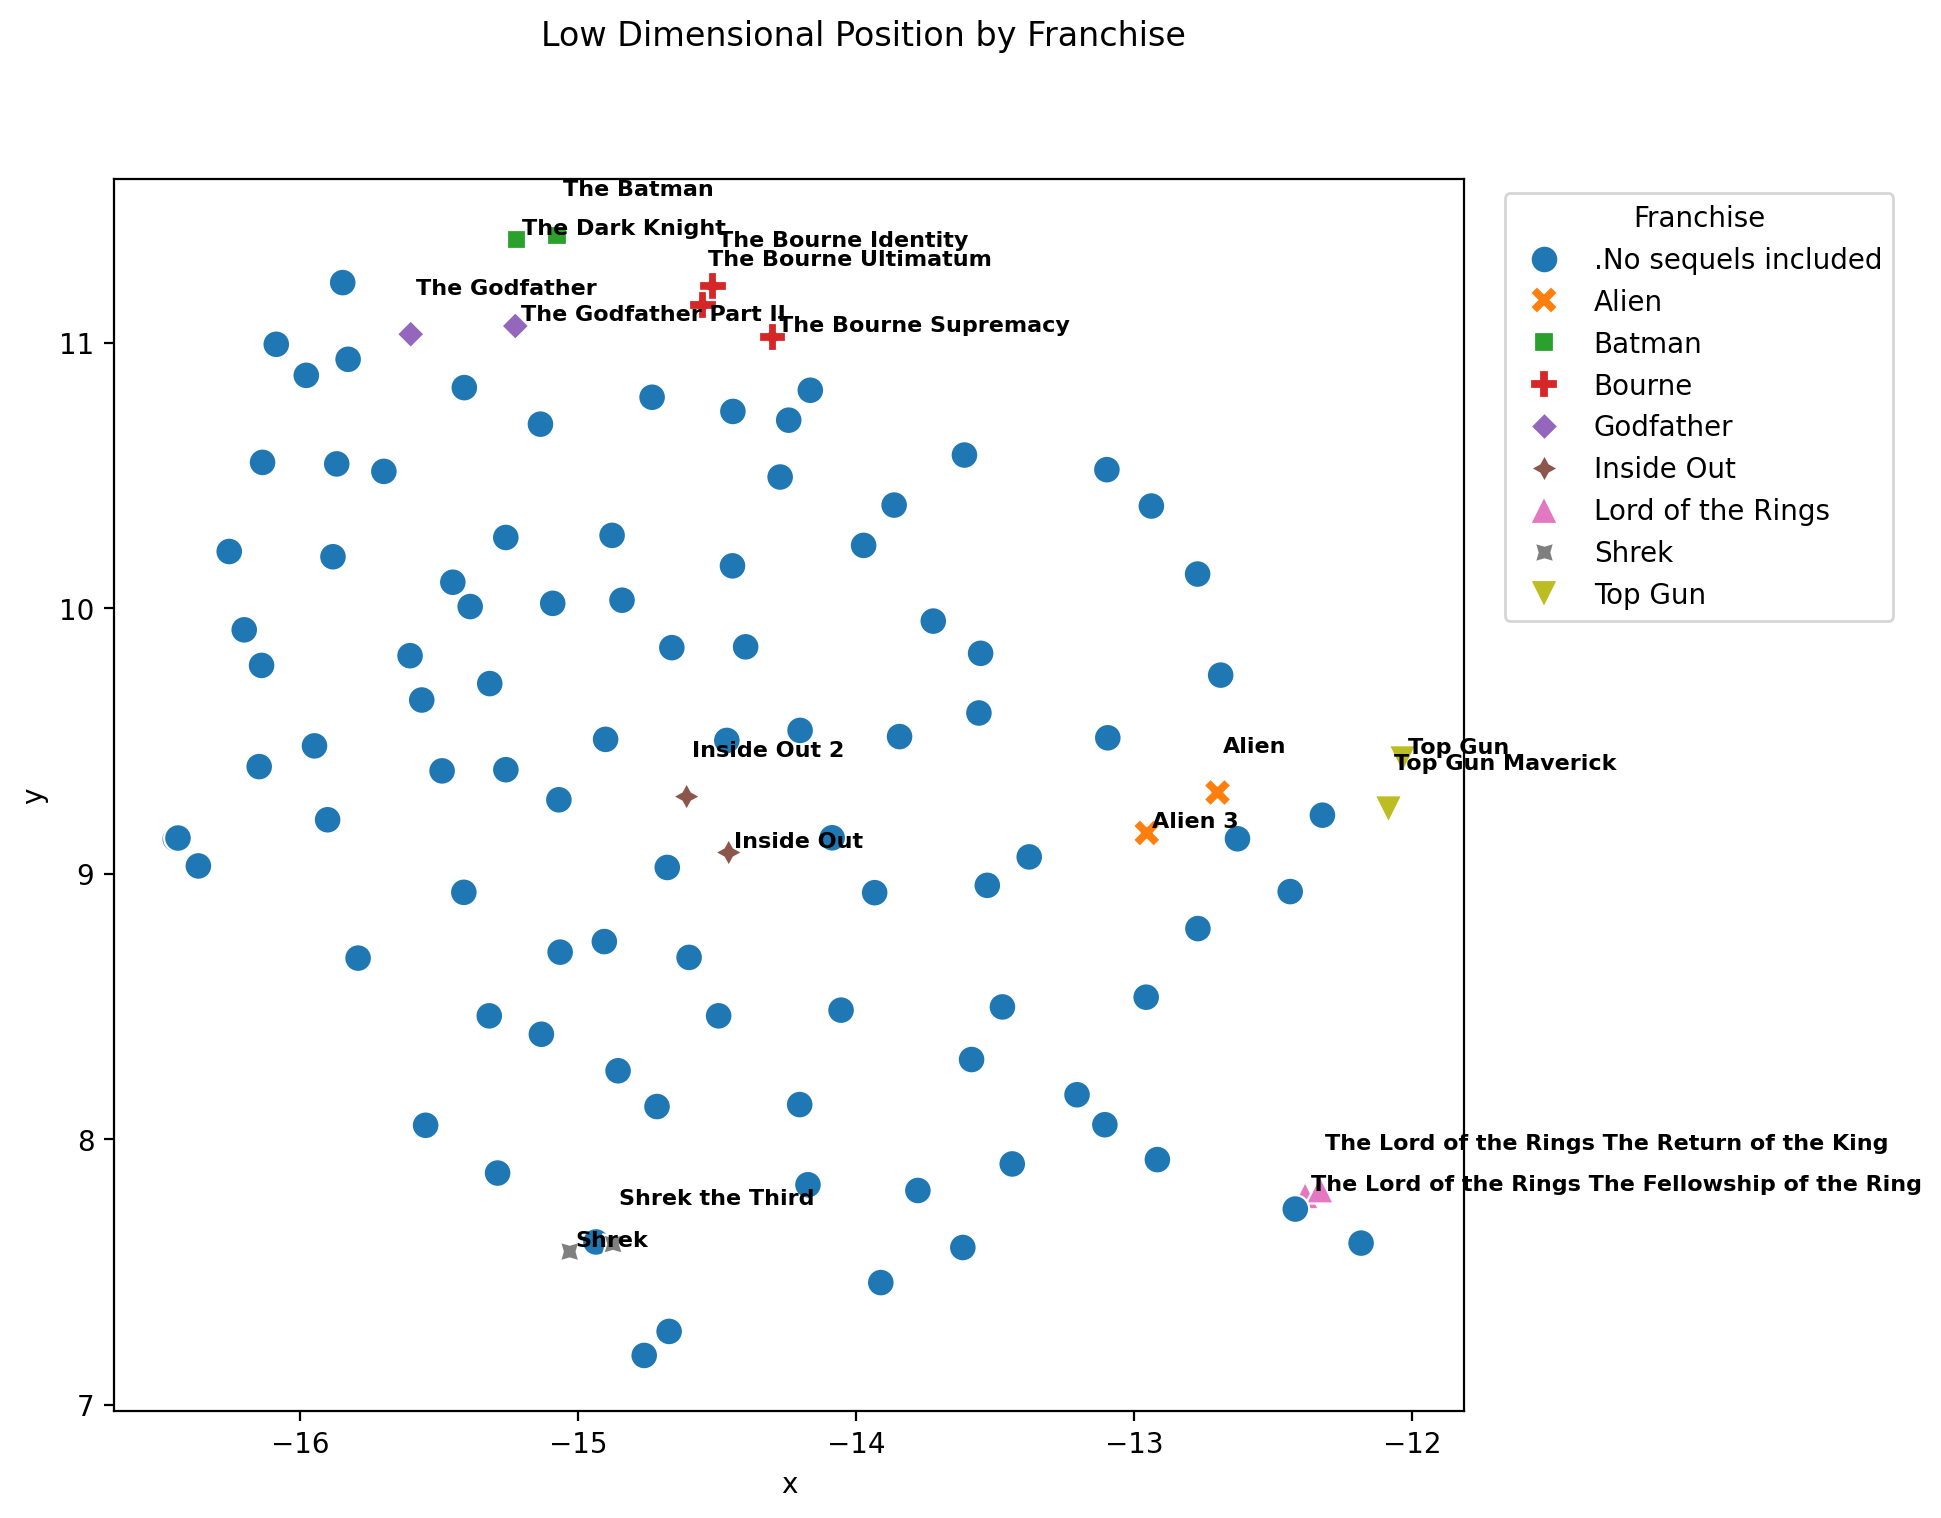

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8), dpi=200)
fig.suptitle("Low Dimensional Position by Franchise")

# Scatter plot on the bottom axis
g = sns.scatterplot(
    data=emblow,
    x='x',
    y='y',
    hue="Franchise",
    style="Franchise",
    s=100,
    ax=axes
)

# Move the legend outside to the right
sns.move_legend(
    g,
    loc="upper left",       # position relative to bbox
    bbox_to_anchor=(1.02, 1)  # (x, y) offset
)

# Make room on the right for the legend
plt.subplots_adjust(right=0.8)

movies_to_label_on_plot = emblow.sort("Franchise").filter(~pl.col("Franchise").str.contains('.', literal=True))

alternating = True
for i in range(movies_to_label_on_plot.shape[0]):
    if alternating is True:
        yplus = 0.13
    alternating = not alternating
    axes.text(
        movies_to_label_on_plot[i, 'x'] + 0.02,            # small offset in x
        movies_to_label_on_plot[i, 'y'] + 0.02 + yplus,            # small offset in y
        movies_to_label_on_plot[i, 'movie_title'], 
        fontsize=8, 
        weight='bold'
    )
    yplus = 0

plt.show()


In [61]:
movies_to_label_on_plot

movie_title
str
"""Alien"""
"""Alien 3"""
"""The Batman"""
"""The Bourne Identity"""
"""The Bourne Supremacy"""
"""The Bourne Ultimatum"""
"""The Dark Knight"""
"""The Godfather Part II"""
"""The Godfather"""


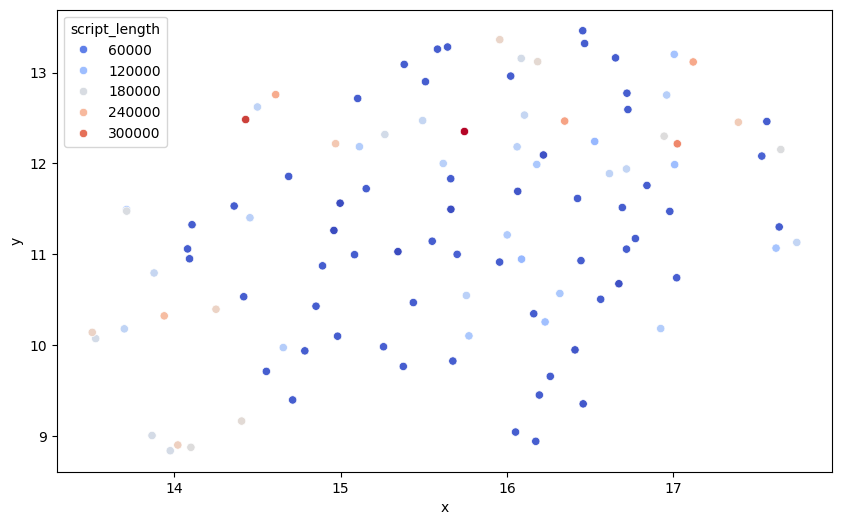

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow,
    x='x',
    y='y',
    hue='script_length',
    palette='coolwarm'
)

plt.show()

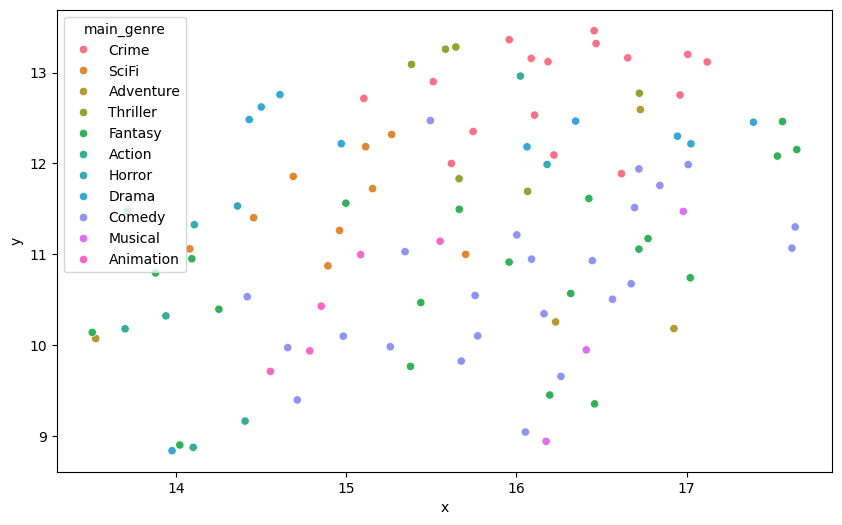

In [65]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(
    emblow.with_columns(
        pl.col("genre").str.contains("Animation").alias("Action_Movie")
    ),
    x='x',
    y='y',
    hue='main_genre'
)

plt.show()